In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import numpy as np
import pandas as pd
import string
import random

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords

import keras
from keras.preprocessing.text import one_hot, Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM, Dense, SpatialDropout1D
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt

import tensorflow as tf
import re

from textattack.augmentation import WordNetAugmenter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Reading Dataset

In [25]:
df = pd.read_excel("data.xlsx")
df.head()

,Product,Job Role,Verbatim Feedback,Sentiment (1=Positive & 0= Negative)
0,IX,XYZ,There is no maintenance menu,0
1,IX,Architect,Very buggy.,0
2,IX,PQR,High quality - standards,1
3,IX,Sales Specialist,Features missing,0
4,IX,Architect,how to do the inter-working,0


In [26]:
df.shape

(387, 4)

In [27]:
test = pd.read_excel("test.xlsx")
test.head()

,Product,Job Role,Verbatim Feedback,Sentiment (1=Positive & 0= Negative)
0,DX,Operations,software releases are always late. Customer-fa...,NaN
1,DX,Architect,documantation is wrong,NaN
2,DX,Sales Specialist,Nice platform- well managed- not perfect-,NaN
3,DX,Architect,lack of features,NaN
4,DX,Sales Specialist,Very good Support from BU,NaN


# Data Augmentation

In [75]:
def clean_text(text):
    # lower text 
    text = text.lower()
    #removing stop words
    text = ' '.join([e_words for e_words in text.split(' ') if e_words not in stopwords.words('english')])
    #removing square brackets
    # text=re.sub('[.*?]', '', text)
    # text=re.sub('+', '', text)
    #removing hyperlink
    # text= re.sub('https?://S+|www.S+', '', text)
    #removing puncuation
    text=re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('n' , '', text)
    #remove words containing numbers
    # text=re.sub('w*dw*' , '', text)
    #tokenizer
    text = nltk.word_tokenize(text)
    #lemmatizer
    wn = nltk.WordNetLemmatizer()
    text = [wn.lemmatize(word) for word in text]
    text = " ".join(text)
    return text

#df["Verbatim Feedback "]= df["Verbatim Feedback "].apply(clean_text)
#test["Verbatim Feedback "]= test["Verbatim Feedback "].apply(clean_text)

In [76]:
def textattack_data_augment(data, target, texattack_augmenter):

  aug_data = []

  aug_label = []

  for text, label in zip(data, target):

    if random.randint(0,2) != 1:

      aug_data.append(text)

      aug_label.append(label)

      continue

    aug_list = texattack_augmenter.augment(text)
    aug_data.append(text)

    aug_label.append(label)




    aug_data.extend(aug_list)

    aug_label.extend([label]*len(aug_list))

  return aug_data, aug_label

In [77]:
word_aug = WordNetAugmenter(pct_words_to_swap=0.2, transformations_per_example=3)
aug_data, aug_lable = textattack_data_augment(df["Verbatim Feedback "].apply(clean_text), df["Sentiment (1=Positive & 0= Negative)"], word_aug)
print(aug_data, aug_lable)
print(len(aug_data))

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


['maiteace meu', 'buggy', 'high quality stadards', 'feature missig', 'have missig', 'lineament missig', 'sport missig', 'iterworkig', 'high price preaggregatio role', 'much deployed', 'overall throughput costraied', 'feel like product step child cocered goe shortly', 'feel like product step minor cocered goe shortly', 'feel like product step tyke cocered goe shortly', 'feel similar product step child cocered goe shortly', 'problem always costat', 'problem incessantly costat', 'problem invariably costat', 'trouble always costat', 'great upgrade', 'improve overall keep good work', 'issue observed', 'ogoig issue farfew issue reported far customer', 'may bug make difficult determie whether software hardware', 'lack documetatio usupported feature feature combiatios', 'parter maiteace meu', 'sw quality low cat meet customer expectatio', 'sw quality first cat meet customer expectatio', 'sw quality low cat receive customer expectatio', 'sw quality low-spirited cat meet customer expectatio', 'h

#LSTM Model

In [78]:
max_fatures = 1000
'''
using tokenizer from keras to convert text 
to their numeric form for embedding
'''
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(aug_data)
X = tokenizer.texts_to_sequences(aug_data)
X = pad_sequences(X)
X.shape
'''
Size of training set is pretty small. This can be increased using data augmentation
Using synonym replacement as in here: 
https://www.analyticsvidhya.com/blog/2022/02/text-data-augmentation-in-natural-language-processing-with-texattack/
'''

'\nSize of training set is pretty small. This can be increased using data augmentation\nUsing synonym replacement as in here: \nhttps://www.analyticsvidhya.com/blog/2022/02/text-data-augmentation-in-natural-language-processing-with-texattack/\n'

In [79]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(lstm_out, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())
'''
Using an LSTM model with the features as shown below
'''

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 55, 128)           128000    
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 55, 128)          0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 196)               254800    
                                                                 
 dense_2 (Dense)             (None, 2)                 394       
                                                                 
Total params: 383,194
Trainable params: 383,194
Non-trainable params: 0
_________________________________________________________________
None


'\nUsing an LSTM model with the features as shown below\n'

In [80]:
Y = pd.get_dummies(aug_lable).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 28)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(563, 55) (563, 2)
(242, 55) (242, 2)


In [81]:
batch_size = 6
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(X_train, Y_train, epochs = 5, batch_size=batch_size, verbose = 2, validation_data = (X_test,Y_test) )

Epoch 1/5
94/94 - 23s - loss: 0.6723 - accuracy: 0.5666 - val_loss: 0.6123 - val_accuracy: 0.6570 - 23s/epoch - 248ms/step
Epoch 2/5
94/94 - 21s - loss: 0.5075 - accuracy: 0.7762 - val_loss: 0.4024 - val_accuracy: 0.8554 - 21s/epoch - 224ms/step
Epoch 3/5
94/94 - 22s - loss: 0.2834 - accuracy: 0.9023 - val_loss: 0.2996 - val_accuracy: 0.8554 - 22s/epoch - 236ms/step
Epoch 4/5
94/94 - 22s - loss: 0.2351 - accuracy: 0.9201 - val_loss: 0.2907 - val_accuracy: 0.8678 - 22s/epoch - 230ms/step
Epoch 5/5
94/94 - 23s - loss: 0.1542 - accuracy: 0.9449 - val_loss: 0.2714 - val_accuracy: 0.8554 - 23s/epoch - 244ms/step


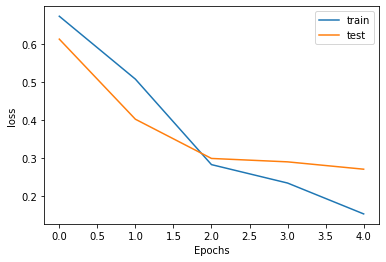

In [82]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [83]:
score = model.evaluate(X_test, Y_test, verbose=2)

8/8 - 0s - loss: 0.2714 - accuracy: 0.8554 - 301ms/epoch - 38ms/step


In [84]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.2714103162288666
Test Accuracy: 0.85537189245224


In [85]:
temp  = model.predict(X_test)

8/8 [==============================] - 1s 42ms/step


In [86]:
model.fit(X, Y, epochs = 5, batch_size=batch_size, verbose = 2)

Epoch 1/5
135/135 - 30s - loss: 0.1604 - accuracy: 0.9366 - 30s/epoch - 224ms/step
Epoch 2/5
135/135 - 31s - loss: 0.1078 - accuracy: 0.9590 - 31s/epoch - 233ms/step
Epoch 3/5
135/135 - 31s - loss: 0.0880 - accuracy: 0.9627 - 31s/epoch - 227ms/step
Epoch 4/5
135/135 - 30s - loss: 0.0867 - accuracy: 0.9677 - 30s/epoch - 222ms/step
Epoch 5/5
135/135 - 30s - loss: 0.0758 - accuracy: 0.9727 - 30s/epoch - 222ms/step


# Predicting rating and  collecting negative feedback

In [87]:
def get(a):
    twt = [a]
    twt = tokenizer.texts_to_sequences(twt)
    twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
    sentiment = model.predict(twt, batch_size=1, verbose=0)[0]
    return sentiment

In [88]:
test['Sentiment (1=Positive & 0= Negative)'] = test['Verbatim Feedback '].map(get)
test['positives'] = list(x[1] for x in test['Sentiment (1=Positive & 0= Negative)'])
jobRoles=test['Job Role'].value_counts()
jobRoles = list(jobRoles.index)
groups = test.groupby(['Job Role'])
val = groups.get_group(jobRoles[0])
negComments = list(val['Verbatim Feedback '][x] for x in val.index if np.argmax(val['Sentiment (1=Positive & 0= Negative)'][x]) == 0)



jobDict = {}
for role in jobRoles:
    val = groups.get_group(role)
    totalPositives = list(val['positives'][x] for x in val.index)
    negComments = list(val['Verbatim Feedback '][x] for x in val.index if np.argmax(val['Sentiment (1=Positive & 0= Negative)'][x]) == 0)
    score = sum(totalPositives)/len(totalPositives)
    jobDict[role] =  (round(score*10),negComments)


soln = pd.DataFrame()
soln['Job Role'] = jobRoles
soln['Rating'] = list(jobDict[x][0] for x in jobRoles)
soln['Negative Feedback'] = list(jobDict[x][1] for x in jobRoles)


pd.set_option('display.max_colwidth', -1)
pd.set_option('display.width', None)


soln.head(3)
'''
listed below is the aggregate negative comments for all the job roles

'''

<ipython-input-88-38010c5997a1>:26: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


'\nlisted below is the aggregate negative comments for all the job roles\n\n'

# Preprocessing functions

In [89]:
!pip -q install language-tool-python  

In [90]:
def sentenceCase(sentences):
    words=sentences.split(". ")
    new=".".join([word.capitalize() for word in words])
    return new

In [91]:
import string
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import language_tool_python    
my_tool = language_tool_python.LanguageTool('en-US')  

def clean_string(text, stem="None"):

    final_string = ""

    # Remove line breaks
    text = re.sub(r'\n', '', text)

    # Remove puncuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = text.strip()
    return text

# Text summarization using DistilBART


In [92]:
!pip -q install sentencepiece
!pip -q install transformers
!pip -q install torch

In [93]:
text = soln['Negative Feedback'][1]

In [94]:
# input list of strings , output text
def getText(a):
  text = ""
  for word in a:
    text += my_tool.correct(clean_string(word).capitalize())
    if(text[-1]==' '):
      text = text[:-1]
    text += ". "
  return text

In [95]:
Soln = soln.drop(['Negative Feedback'],axis = 1)

In [96]:
from transformers import pipeline
summarizer = pipeline("summarization")

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [97]:
Summary2 = []
for x in soln['Negative Feedback']:
    if x == []:
        Summary2.append("-")
        continue
    # text = x
    preprocess_text = getText(x)
    # preprocess_text = ". ".join([(str(item)) if str(item)[-1] != '.' else (str(item))[:-1] for item in text])
    if len(preprocess_text.split()) >= 30:
        summarized = summarizer(preprocess_text, min_length=10, max_length=30)
        Summary2.append(summarized[0]['summary_text'])
    else:
        Summary2.append(preprocess_text)

In [98]:
Soln['Summary from BART Model'] = Summary2

In [99]:
Soln

,Job Role,Rating,Summary from BART Model
0,Architect,3,Feature gap gap complete documentation complete documentation . Lack feature. Support important overworking. Lack basic feature lot bug. Aim feature parity. Lack
1,Engineer,4,May glitch bug critical bug lead service outage . Hard get support eve get. Improvement software from improvement required . May bug. May bug .
2,Support,6,Poor drop accounting troubleshooting capability support pretty much guess work clue. Frequent occurrence work due defective hardware. Product big change make customer embrace deploy.
3,XYZ,7,Always wondering every problem hit defect CORIG issue supported. Security several issues.
4,Manager,2,Several issues. Lack service. Dissatisfaction due lack debugability sup portability limit seeds drastically improved including documentation. Hit bug. Release delay. Sufficient troubleshooting capability serviceability.
5,Systems Engineer,7,EED improvement. Feature outlaid properly. This license complicated.
6,Sales Specialist,7,This look improved. Critical feature certain multicasting. Limited performance slow feature supportperformace EED improve match requirement EW market position.
7,PQR,4,Software quality issue caused network outage escalation. Timing support. Low product quality.
8,Operations,6,SW quality cover. May bug.
9,Solutions,7,Improvement. Lack scalability.


In [ ]:
# get('This is good')


# def get(a):
#     twt = [a]
#     # vectorizing the tweet by the pre-fitted tokenizer instance
#     twt = tokenizer.texts_to_sequences(twt)
#     # padding the tweet to have exactly the same shape as `embedding_2` input
#     twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
#     # print(twt)
#     sentiment = model.predict(twt, batch_size=1, verbose=0)[0]
#     return sentiment


# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)
 
# All dataframes hereafter reflect these changes.
# display(df)


# test['positives'] = list(x[1] for x in test['Sentiment (1=Positive & 0= Negative)'])

# Summary2

# Soln.rename(columns = {'Summary for negative comments': 'Using t5'})

In [ ]:
# preprocess_text = ". ".join([(str(item)) if str(item)[-1] != '.' else (str(item))[:-1] for item in text])

# preprocess_text
# t5_prepared_Text = "summarize: "+ preprocess_text
# tokenized_text = tokenizer.encode(t5_prepared_Text, return_tensors="pt").to(device)
# tokenized_text
# summary_ids = model.generate(tokenized_text,
#                                     num_beams=4,
#                                     no_repeat_ngram_size=2,
#                                     min_length=10,
#                                     max_length=40,
#                                     early_stopping=True)
# output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
# sentenceCase(output)

In [ ]:
# Summary = []
# for x in soln['Negative Feedback']:
#     if x == []:
#         Summary.append("-")
#         continue
#     text = x
#     preprocess_text = ". ".join([(str(item)) if str(item)[-1] != '.' else (str(item))[:-1] for item in text])
#     t5_prepared_Text = "summarize: "+preprocess_text
#     tokenized_text = tokenizer.encode(t5_prepared_Text, return_tensors="pt").to(device)
#     summary_ids = model.generate(tokenized_text,
#                                     num_beams=4,
#                                     no_repeat_ngram_size=2,
#                                     min_length=10,
#                                     max_length=30,
#                                     early_stopping=True)
    
#     output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
#     Summary.append(sentenceCase(output))

In [ ]:
# Bert
# !pip install bert-extractive-summarizer

In [ ]:
# soln['Using BERT'] = soln['Negative Feedback'].map(getTextForBert)
# soln

In [ ]:
# from transformers import PegasusForConditionalGeneration
# from transformers import PegasusTokenizer
# from transformers import pipeline

In [ ]:
# from summarizer import Summarizer,TransformerSummarizer

# bert_model = Summarizer()

# def getTextForBert(a):
#     sentence = getText(a)
#     bert_summary = ''.join(bert_model(sentence))
#     return bert_summary

In [ ]:
# text = soln['Negative Feedback'][8]
# # preprocess_text = ". ".join([(str(item)) if str(item)[-1] != '.' else (str(item))[:-1] for item in text])
# preprocess_text = ". ".join([ my_tool.correct(clean_string(item).capitalize()) for item in text])
# print(len(preprocess_text.split()))
# print(preprocess_text)

In [ ]:
# import torch
# import json 
# from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config

In [ ]:
# model = T5ForConditionalGeneration.from_pretrained('t5-small')
# tokenizer = T5Tokenizer.from_pretrained('t5-small')
# device = torch.device('cpu')

In [ ]:
# embed_dim = 128 #New
# lstm_out = 196 #New

# model = Sequential()
# model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
# model.add(SpatialDropout1D(0.4))
# model.add(Dropout(0.5)) #New
# model.add(LSTM(lstm_out, dropout=0.4, recurrent_dropout=0.4))
# model.add(Dense(50, activation="sigmoid")) #New
# model.add(Dropout(0.5)) #New
# model.add(Dense(2,activation='softmax'))
# model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
# #model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
# print(model.summary())